In [1]:
from TVB.tvb_wrapper import TVBWrapper
env = TVBWrapper()

2024-10-29 15:43:35,183 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2024-10-29 15:43:35,250 - INFO - tvb.simulator.monitors - Projection configured gain shape (65, 76)


In [2]:
env.reset()
for i in range(1000):
    action = env.action_space.sample()
    state, reward, _, done, _ = env.step(action)
    if done:
        break

2024-10-29 15:43:36,840 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-10-29 15:43:48,901 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-10-29 15:43:49,035 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-10-29 15:43:49,122 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-10-29 15:43:49,207 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-10-29 15:43:49,311 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-10-29 15:43:49,398 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-10-29 15:43:49,484 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
2024-10-29 15:43:49,590 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig 

KeyboardInterrupt: 

Debugging the wrapper.

In [59]:
from tvb.simulator.lab import *
import numpy as np

In [60]:
%matplotlib inline

In [61]:
timestep=10
history_len=200
max_len=6000
dt=0.05
model = models.Epileptor()
model.variables_of_interest = ('x1', 'y1', 'z', 'x2', 'y2', 'g')
model.x0 = np.ones((76))*-2.4
model.x0[[62,47,40]] = np.ones((3))*-1.6
# 69: rTCL, 72: rTCV, minor epileptogenic regions
model.x0[[69,72]] = np.ones((2))*-1.8
# in one single tutorial it is connectiity.Connectivity(load_default=True), in others it is connectivity.Connectivity.from_file(). Ehhhhhhh
conn = connectivity.Connectivity.from_file()
# what does difference coupling functions mean?
# https://github.com/the-virtual-brain/tvb-library/blob/trunk/tvb/simulator/coupling.py
coupl = coupling.Difference(a=np.array([1.]))
hiss = noise.Additive(nsig=np.array([0., 0., 0., 0.0003, 0.0003, 0.]))
integrator = integrators.HeunStochastic(dt=dt, noise=hiss)
dt = dt  # the dt for integrator, unit is ms
# load the default region mapping
rm = region_mapping.RegionMapping.from_file()

# Initialise EEG Monitor with period in physical time
mon_raw = monitors.Raw()
mon_EEG = monitors.EEG.from_file()
EEG_labels = mon_EEG.sensors.labels  # channel names
mon_EEG.region_mapping=rm
mon_EEG.period=1. 

# Bundle them
what_to_watch = (mon_raw, mon_EEG)

sim = simulator.Simulator(model=model, connectivity=conn,
                        coupling=coupl, 
                        integrator=integrator, monitors=what_to_watch)
sim.configure()
init_length = max(4000,timestep*history_len*2)

2024-10-29 14:29:10,046 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2024-10-29 14:29:10,114 - INFO - tvb.simulator.monitors - Projection configured gain shape (65, 76)


In [62]:
(traw, raw), (tEEG, EEG) = sim.run(simulation_length=init_length)
EEG = EEG[:,3,:,0] - EEG[:,0,:,0]
EEG /= (np.max(EEG,0) - np.min(EEG,0))
EEG -= np.mean(EEG,0)


Text(0.5, 1.0, 'EEG')

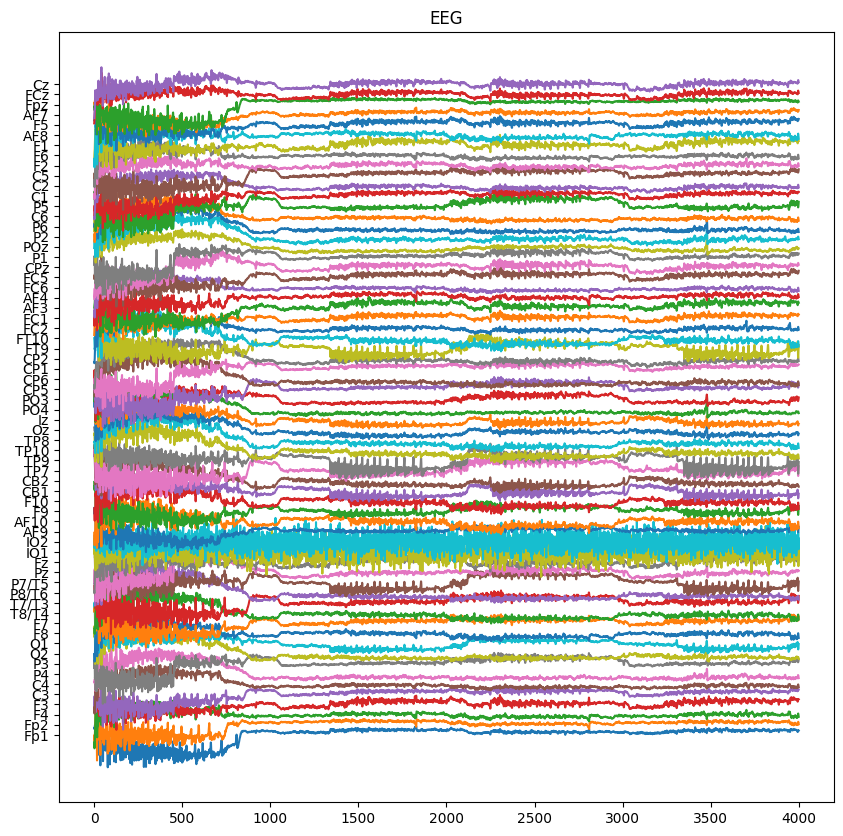

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(tEEG,5*EEG + np.r_[:len(EEG_labels)])
plt.yticks(np.r_[:65], mon_EEG.sensors.labels)
plt.title("EEG")

In [67]:
eqn_t = equations.Linear()
eqn_t.parameters["a"] = 0.00
eqn_t.parameters["b"] = 10
weighting = np.zeros((76))
weighting[[69, 72]] = np.array([2.])
stimulus = patterns.StimuliRegion(temporal = eqn_t,
                                  connectivity = conn, 
                                  weight = weighting)
stimulus.configure_space()

In [66]:
sim = simulator.Simulator(model=model, connectivity=conn,
                        coupling=coupl, 
                        integrator=integrator, monitors=what_to_watch,
                        initial_conditions=raw, stimulus=stimulus)
sim.configure()
(traw, raw), (tEEG, EEG) = sim.run(simulation_length=timestep)

2024-10-29 14:31:44,140 - ERROR - tvb.simulator.simulator - Bad Simulator.integrator.noise.nsig shape: (6, 1, 1)
